In [1]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shapely.wkt
import geopandas as gpd
import contextily as cx
import warnings

warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

# load and process FAF data

Index(['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
       'tons_2018', 'tons_2019', 'tons_2020', 'tons_2022', 'tons_2023',
       'tons_2025', 'tons_2030', 'tons_2035', 'tons_2040', 'tons_2045',
       'tons_2050', 'value_2017', 'value_2018', 'value_2019', 'value_2020',
       'value_2022', 'value_2023', 'value_2025', 'value_2030', 'value_2035',
       'value_2040', 'value_2045', 'value_2050', 'current_value_2018',
       'current_value_2019', 'tmiles_2017', 'tmiles_2018', 'tmiles_2019',
       'tmiles_2020', 'tmiles_2022', 'tmiles_2023', 'tmiles_2025',
       'tmiles_2030', 'tmiles_2035', 'tmiles_2040', 'tmiles_2045',
       'tmiles_2050'],
      dtype='object')


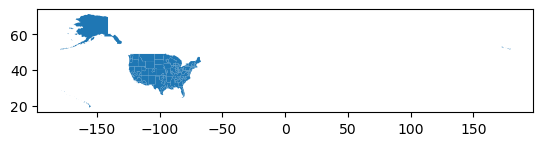

In [2]:
# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

#define scenario input
analysis_year = 2017
us_ton_to_ton = 0.907185
miles_to_km = 1.60934
shipment_load_attr = 'tons_' + str(analysis_year)
shipment_tonmile_attr = 'tmiles_' + str(analysis_year)
region_name = 'BayArea'
# region_code = [531, 532, 539, 411] # seattle
region_code = [62, 64, 65, 69] #Bay Area

path_to_write = 'inputs_' + region_name # update this based on analysis region 
path_to_plot = 'plots_' + region_name # update this based on analysis region
faf_data = read_csv('Validation/' + 'FAF5.3.csv', sep = ',')
print(faf_data.columns)
faf_zone_file = 'RawData/FAF5Zones.geojson'
faf_zone = gpd.read_file(faf_zone_file)
faf_zone.plot()

crosswalk_file = 'SynthFirm_parameters/international_trade_zone_lookup.csv'
international_zonal_crosswalk = read_csv(crosswalk_file)

In [3]:
# checking FAF data
col_to_keep = ['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
               'value_2017', 'tmiles_2017']
faf_data = faf_data[col_to_keep]
faf_val_by_trade_type = \
faf_data.groupby('trade_type')[['tons_2017', 'value_2017', 'tmiles_2017']].sum()
print(faf_val_by_trade_type)

faf_data = faf_data.loc[faf_data['trade_type'] != 1]

               tons_2017    value_2017   tmiles_2017
trade_type                                          
1           1.747758e+07  1.508175e+07  4.334811e+06
2           1.193337e+06  2.270006e+06  5.502540e+05
3           1.137920e+06  1.555032e+06  5.428024e+05


In [4]:
# check value to canada
canada_import = faf_data.loc[faf_data['trade_type'] == 2]
canada_import = \
canada_import.loc[canada_import['fr_orig'] == 801]
print(canada_import[['tons_2017', 'value_2017']].sum())

canada_export = faf_data.loc[faf_data['trade_type'] == 3]
canada_export = \
canada_export.loc[canada_export['fr_dest'] == 801]
print(canada_export[['tons_2017', 'value_2017']].sum())

# seems reasonable compare to BTS values: 
# https://www.bts.gov/content/value-us-land-exports-and-imports-canada-and-mexico-mode


tons_2017     438821.905445
value_2017    331565.851430
dtype: float64
tons_2017     197855.810142
value_2017    328470.310420
dtype: float64


In [5]:
# define import-export in the region

faf_crosswalk = \
international_zonal_crosswalk[['FAFID',	'CFS_CODE','CFS_NAME']]

faf_crosswalk = faf_crosswalk.drop_duplicates()
# print(faf_crosswalk['CFS_NAME'].unique())
      
regional_import = faf_data.loc[faf_data['trade_type'] == 2]
regional_import = \
regional_import.loc[regional_import['dms_orig'].isin(region_code)]

regional_import['fr_orig'] = regional_import['fr_orig'].astype(int)

faf_crosswalk['FAFID'] = faf_crosswalk['FAFID'].astype(int)

regional_import = pd.merge(regional_import, faf_crosswalk,
                           left_on = 'fr_orig', 
                           right_on = 'FAFID', how = 'left')
regional_import = regional_import.drop(columns = 'FAFID')
regional_import.loc[:, 'distance'] = \
1000 * regional_import.loc[:, 'tmiles_2017'] / regional_import.loc[:, 'tons_2017']

# regional_import = regional_import.loc[regional_import['sctg2'] != 37]
# also drop import crude oil as it is not going through domestic mode
# regional_import = regional_import.loc[regional_import['sctg2'] != 16]
print('total import within selected region:')
print(regional_import[['tons_2017', 'value_2017', 'tmiles_2017']].sum())

regional_export = faf_data.loc[faf_data['trade_type'] == 3]
regional_export = \
regional_export.loc[regional_export['dms_dest'].isin(region_code)]

regional_export['dms_dest'] = regional_export['dms_dest'].astype(int)

regional_export = pd.merge(regional_export, faf_crosswalk,
                           left_on = 'fr_dest', 
                           right_on = 'FAFID', how = 'left')
regional_export = regional_export.drop(columns = 'FAFID')
# drop non-auto transportation equipment
# regional_export = regional_export.loc[regional_export['sctg2'] != 37]


regional_export.loc[:, 'distance'] = \
1000 * regional_export.loc[:, 'tmiles_2017'] / regional_export.loc[:, 'tons_2017']
print('total export within selected region:')
print(regional_export[['tons_2017', 'value_2017', 'tmiles_2017']].sum())

regional_export.head(5)

total import within selected region:
tons_2017      45016.346314
value_2017     77498.644619
tmiles_2017    13508.132272
dtype: float64
total export within selected region:
tons_2017      23386.930794
value_2017     55604.134342
tmiles_2017    10186.626633
dtype: float64


,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,tons_2017,value_2017,tmiles_2017,CFS_CODE,CFS_NAME,distance
0,NaN,61,62,801.0,NaN,4,4.0,1,3,3,0.000113,0.008739,0.000042,C,Canada,371.681416
1,NaN,61,64,801.0,NaN,4,4.0,1,3,3,0.011395,0.445171,0.003942,C,Canada,345.941202
2,NaN,61,69,801.0,NaN,1,4.0,1,3,2,0.000000,0.000000,0.000000,C,Canada,NaN
3,NaN,62,64,801.0,NaN,1,4.0,1,3,2,0.001286,0.050249,0.000150,C,Canada,116.640747
4,NaN,63,62,801.0,NaN,4,4.0,1,3,3,0.000026,0.001989,0.000012,C,Canada,461.538462


In [6]:
# check mode split
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}
regional_import.loc[:, 'mode_def'] = \
regional_import.loc[:, 'dms_mode'].map(mode_lookup)

regional_export.loc[:, 'mode_def'] = \
regional_export.loc[:, 'dms_mode'].map(mode_lookup)

# mode split by tonnage
import_mode_split = \
regional_import.groupby('mode_def')[['tons_2017']].sum()
import_mode_split = import_mode_split.reset_index()
import_mode_split.loc[:, 'direction'] = 'import'
export_mode_split = \
regional_export.groupby('mode_def')[['tons_2017']].sum()
export_mode_split = export_mode_split.reset_index()
export_mode_split.loc[:, 'direction'] = 'export'
mode_split_faf = pd.concat([import_mode_split, export_mode_split] )

mode_split_faf.loc[:, 'fraction'] = \
mode_split_faf.loc[:, 'tons_2017'] / \
mode_split_faf.groupby(['direction'])['tons_2017'].transform('sum')
mode_split_faf.to_csv(os.path.join(path_to_write, 'port', 'FAF_mode_split.csv'),
                      index = False)

In [6]:
# write to SynthFirm inputs
regional_import.to_csv(os.path.join(path_to_write, 'port', 'FAF_regional_import.csv'),
                      index = False)

regional_export.to_csv(os.path.join(path_to_write, 'port', 'FAF_regional_export.csv'),
                      index = False)

(10.0, 4500.0)

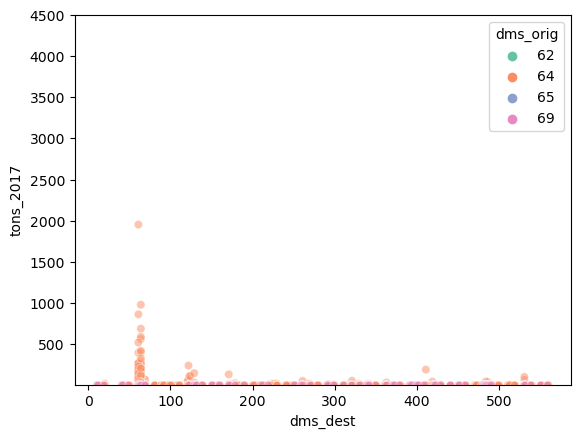

In [5]:
# check diversity
sns.scatterplot(data = regional_import, x = 'dms_dest', 
                y= 'tons_2017',hue = 'dms_orig', alpha = 0.5,
               palette = 'Set2')
plt.ylim([10, 4500])

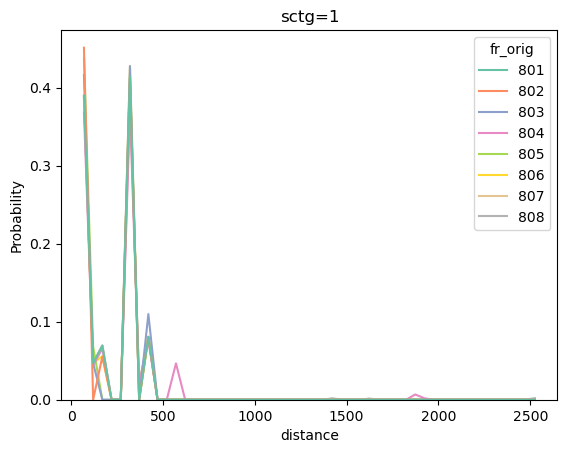

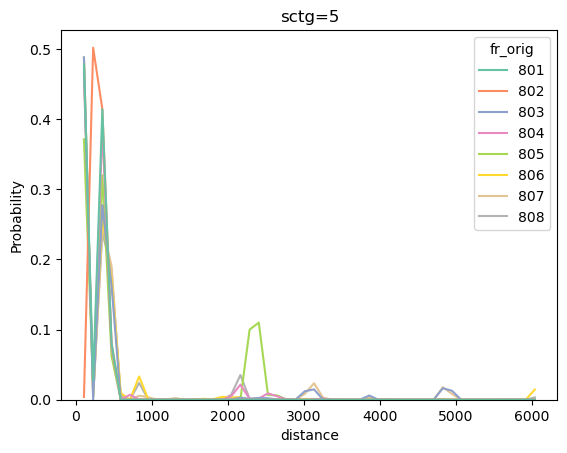

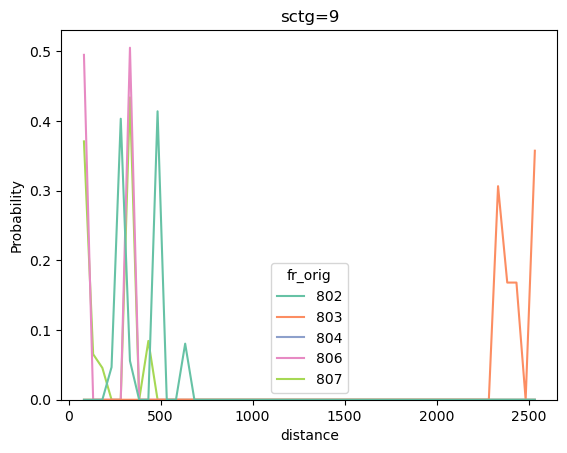

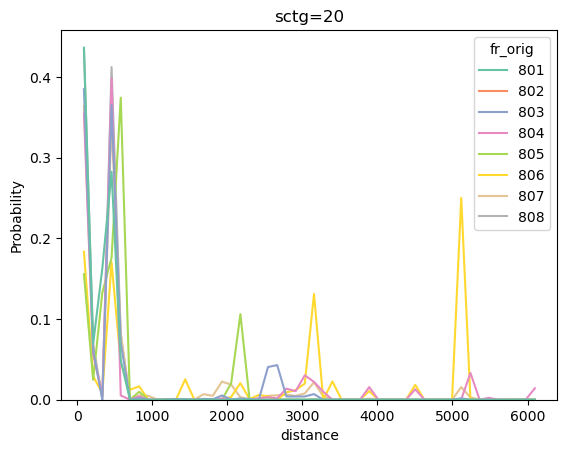

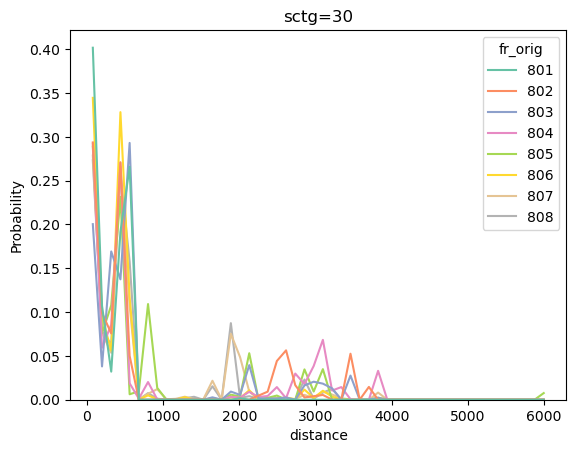

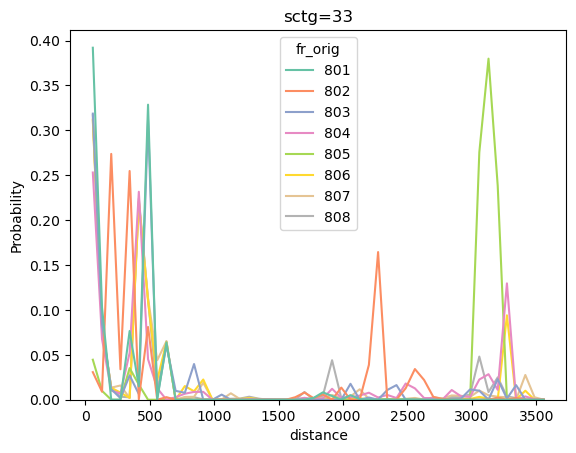

In [6]:
# check if same commodity from different countries goes to same destination
# regional_import.loc[:, 'distance'] = \
# 1000 * regional_import.loc[:, 'tmiles_2017'] / regional_import.loc[:, 'tons_2017']
selected_sctg = [1, 5, 9, 20, 30, 33]

for sctg in selected_sctg:
    region_import_plot = \
    regional_import.loc[regional_import['sctg2'] == sctg]
    sns.histplot(data=region_import_plot, bins= 50,
                 x="distance", weights = 'tons_2017', hue="fr_orig",
                stat = 'probability', common_norm = False, 
                 element = 'poly', fill = False, palette = 'Set2')
    plt.title('sctg=' + str(sctg))
    plt.show()

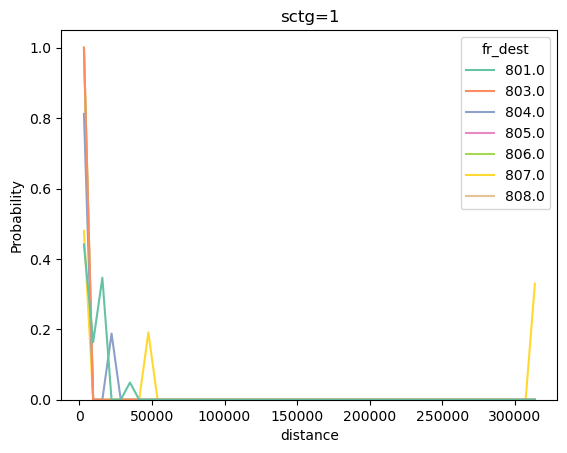

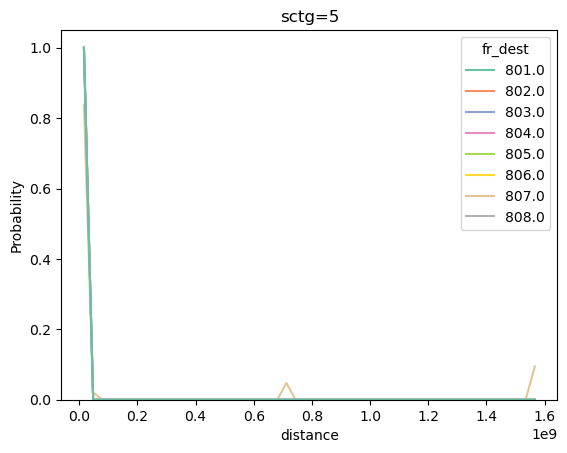

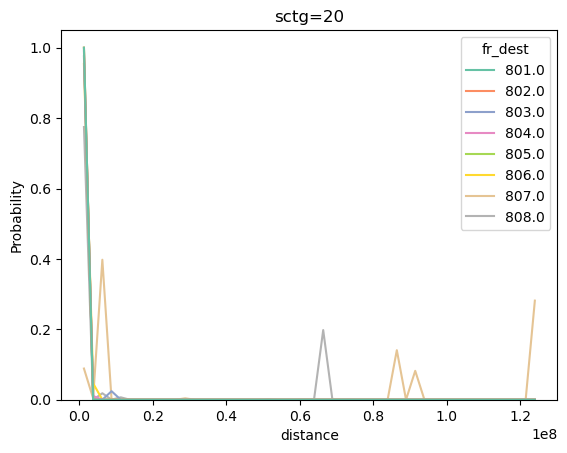

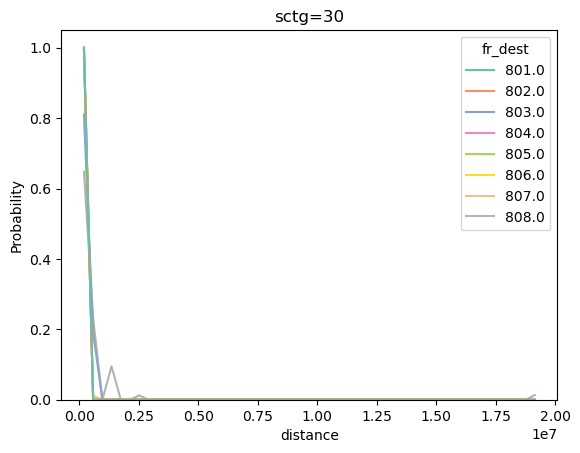

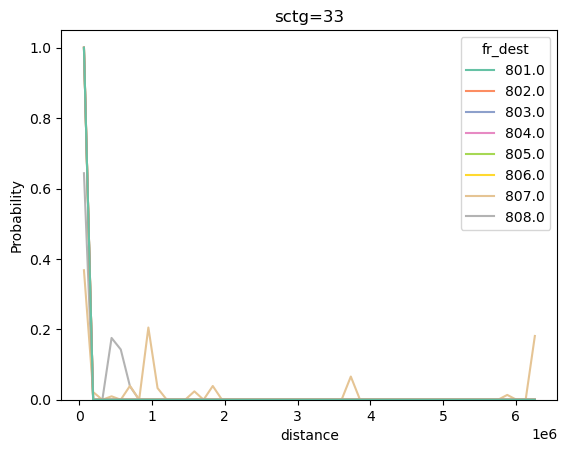

In [8]:
# check if same commodity from different countries goes to same destination
# regional_export.loc[:, 'distance'] = \
# 1000 * regional_export.loc[:, 'tmiles_2017'] / regional_import.loc[:, 'tons_2017']
selected_sctg = [1, 5, 20, 30, 33]

for sctg in selected_sctg:
    regional_export_plot = \
    regional_export.loc[regional_export['sctg2'] == sctg]
    sns.histplot(data=regional_export_plot, bins= 50,
                 x="distance", weights = 'tons_2017', hue="fr_dest",
                stat = 'probability', common_norm = False, 
                 element = 'poly', fill = False, palette = 'Set2')
    plt.title('sctg=' + str(sctg))
    plt.show()

# load and process USATO data

In [7]:
# load USATO data
port_file = 'RawData/Port/port_code_cbp.csv'
list_of_ports = read_csv(port_file)

port_loc_file = 'SynthFirm_parameters/port_location_CA_WA_OR.geojson'
port_locations = gpd.read_file(port_loc_file)

import_flow_file = 'RawData/Port/Flow/SF and Seattle Port-level Imports (2017)_with OR.csv'
regional_import_flow = read_csv(import_flow_file)

export_flow_file = 'RawData/Port/Flow/SF and Seattle Port-level Exports (2017)_with OR.csv'
regional_export_flow = read_csv(export_flow_file)

commodity_crosswalk_file = 'SynthFirm_parameters/hs_to_sctg.csv'
sctg_crosswalk = read_csv(commodity_crosswalk_file)

study_region_definition = region_name + '_freight.geojson'
study_region = gpd.read_file(os.path.join(path_to_write, study_region_definition))
study_region.head(5)

,GEOID,FAFID,MESOZONE,CBPZONE,geometry
0,159,159,20028,28,"MULTIPOLYGON (((-155.43286 20.14521, -155.4315..."
1,151,151,20027,27,"MULTIPOLYGON (((-166.38653 23.84636, -166.3842..."
2,487,487,20112,112,"POLYGON ((-99.53688 27.59560, -99.53693 27.595..."
3,489,489,20114,114,"POLYGON ((-100.00040 35.59223, -100.00040 35.5..."
4,485,485,20110,110,"POLYGON ((-105.99000 32.00235, -105.98698 32.0..."


In [8]:
print(len(port_locations))

# print(list_of_ports.columns)
# port_locations.head(5)
list_of_ports.loc[:, 'PORTID'] = \
list_of_ports.loc[:, 'CBP Port Location'].str.split('(').str[0]
list_of_ports.loc[:, 'PORTID'] = \
list_of_ports.loc[:, 'PORTID'].str[:-1]
port_locations_with_id = pd.merge(port_locations,
                                  list_of_ports,
                                  on = 'PORTID',
                                  # right_on = 'CBP Port Location',
                                  how = 'left')
print(len(port_locations_with_id))
port_locations_with_id.head(5)

48
48


,NAME,STATE,PORTID,TYPE,geometry,Export Port Code,CBP Port Location,is_airport,Vessel,Air,Rail,Road,Fixed
0,san francisco intl,California,"San Francisco International Airport, CA",Airport,"POLYGON ((-122.38791 37.60778, -122.39251 37.6...",2801,"San Francisco International Airport, CA (Port)",1,N,Y,N,N,N
1,fresno air terminal,California,"Fresno, CA",Airport,"POLYGON ((-119.71791 36.76525, -119.71791 36.7...",2803,"Fresno, CA (Port)",1,Y,Y,N,N,N
2,san jose international,California,"San Jose International Airport, CA",Airport,"POLYGON ((-121.92090 37.35086, -121.92697 37.3...",2834,"San Jose International Airport, CA (Port)",1,N,Y,N,N,N
3,sacramento metropolitan,California,"Sacramento International Airport, CA",Airport,"POLYGON ((-121.59067 38.67326, -121.59106 38.6...",2835,"Sacramento International Airport, CA (Port)",1,Y,Y,N,Y,N
4,portland intl,Oregon,"Portland International Airport, OR",Airport,"POLYGON ((-122.60812 45.57772, -122.61452 45.5...",2910,"Portland International Airport, OR (Port)",1,N,Y,N,N,N


In [9]:
# assign port to FAF zone
port_locations_with_id_df = port_locations_with_id.drop(columns = 'geometry')
port_locations_centroid = port_locations_with_id["geometry"].centroid
port_locations_centroid = \
gpd.GeoDataFrame(geometry = gpd.GeoSeries(port_locations_centroid))
port_locations_centroid = pd.concat([port_locations_centroid, 
                               port_locations_with_id_df], axis = 1)
port_locations_centroid.head(5)
faf_zone = faf_zone.to_crs('EPSG:4326')
port_in_faf = \
port_locations_centroid.sjoin_nearest(faf_zone, how="left")
port_in_faf.head(5)

,geometry,NAME,STATE,PORTID,TYPE,Export Port Code,CBP Port Location,is_airport,Vessel,Air,Rail,Road,Fixed,index_right,FAF
0,POINT (-122.38266 37.62047),san francisco intl,California,"San Francisco International Airport, CA",Airport,2801,"San Francisco International Airport, CA (Port)",1,N,Y,N,N,N,11,064
1,POINT (-119.71807 36.77570),fresno air terminal,California,"Fresno, CA",Airport,2803,"Fresno, CA (Port)",1,Y,Y,N,N,N,12,065
2,POINT (-121.92835 37.36269),san jose international,California,"San Jose International Airport, CA",Airport,2834,"San Jose International Airport, CA (Port)",1,N,Y,N,N,N,11,064
3,POINT (-121.59156 38.69981),sacramento metropolitan,California,"Sacramento International Airport, CA",Airport,2835,"Sacramento International Airport, CA (Port)",1,Y,Y,N,Y,N,9,062
4,POINT (-122.59607 45.58747),portland intl,Oregon,"Portland International Airport, OR",Airport,2910,"Portland International Airport, OR (Port)",1,N,Y,N,N,N,94,411


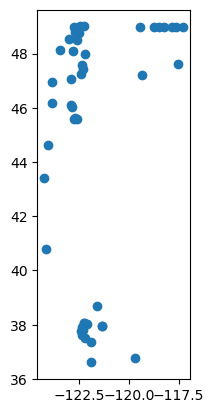

In [12]:
# write processed port flow
port_in_faf.plot()
# port_in_faf = port_in_faf.drop(columns = ['index_right'])
port_in_faf.to_file('RawData/Port/port_location_with_faf_id.geojson',
                   driver="GeoJSON")

In [13]:
# process port in study area
port_in_faf['FAF'] = port_in_faf['FAF'].astype(int)
port_in_region = \
port_in_faf.loc[port_in_faf['FAF'].isin(region_code)]
study_region = study_region.to_crs('EPSG:4326')
# print(port_in_region.columns)
# print(study_region.columns)
port_in_region = \
port_in_region.sjoin_nearest(study_region, how="left")
port_in_region = port_in_region.drop(columns = ['index_right'])
port_in_region[['lat', 'lon']] = \
    port_in_region.apply(lambda p: (p.geometry.y, p.geometry.x), axis=1, 
                        result_type='expand')
port_in_region_df = port_in_region.drop(columns = 'geometry')

port_in_region_df.head(5)

,NAME,STATE,PORTID,TYPE,Export Port Code,CBP Port Location,is_airport,Vessel,Air,Rail,Road,Fixed,FAF,GEOID,FAFID,MESOZONE,CBPZONE,lat,lon
0,san francisco intl,California,"San Francisco International Airport, CA",Airport,2801,"San Francisco International Airport, CA (Port)",1,N,Y,N,N,N,64,060819843001,64,060819843001,06081,37.620472,-122.382664
1,fresno air terminal,California,"Fresno, CA",Airport,2803,"Fresno, CA (Port)",1,Y,Y,N,N,N,65,060190031041,65,060190031041,06019,36.775701,-119.718073
2,san jose international,California,"San Jose International Airport, CA",Airport,2834,"San Jose International Airport, CA (Port)",1,N,Y,N,N,N,64,060855051002,64,060855051002,06085,37.362693,-121.928355
3,sacramento metropolitan,California,"Sacramento International Airport, CA",Airport,2835,"Sacramento International Airport, CA (Port)",1,Y,Y,N,Y,N,62,060670071011,62,060670071011,06067,38.699810,-121.591561
9,eureka,None,"Eureka, CA",Port,2802,"Eureka, CA (Port)",0,Y,N,N,N,N,69,060230013001,69,060230013001,06023,40.791605,-124.191425


In [14]:
port_in_region.to_file(os.path.join(path_to_write, 'Port/port_location_in_region.geojson'),
                   driver="GeoJSON")

port_in_region_df.to_csv(os.path.join(path_to_write, 'Port/port_location_in_region.csv'),
                   index = False)

In [15]:
# select port and flow in study region, and generete attributes
international_end_lookup = \
international_zonal_crosswalk[['Country', 'CFS_CODE', 'CFS_NAME']]

international_end_lookup = \
international_end_lookup.drop_duplicates(subset= 'Country')

print(international_end_lookup.CFS_NAME.unique())

# parsing import
regional_import_flow['Customs Value (Gen) ($US)'] = \
regional_import_flow['Customs Value (Gen) ($US)'].astype(float)

regional_import_flow.loc[:, 'HS Code'] = \
regional_import_flow.loc[:, 'Commodity'].str.split(' ').str[0]

regional_import_flow.loc[:, 'HS Code'] = \
regional_import_flow.loc[:, 'HS Code'].astype(int)

regional_import_flow = pd.merge(regional_import_flow,
                               international_end_lookup,
                               on = 'Country', how = 'left')

# parsing export
regional_export_flow['Total Exports Value ($US)'] = \
regional_export_flow['Total Exports Value ($US)'].astype(float)

regional_export_flow.loc[:, 'HS Code'] = \
regional_export_flow.loc[:, 'Commodity'].str.split(' ').str[0]

regional_export_flow.loc[:, 'HS Code'] = \
regional_export_flow.loc[:, 'HS Code'].astype(int)

regional_export_flow = pd.merge(regional_export_flow,
                               international_end_lookup,
                               on = 'Country', how = 'left')
regional_export_flow.head(5)

['Europe & Africa' 'Asia & Oceania' 'Canada' 'Mexico'
 'Rest of the Americas']


,Port,Commodity,Country,Time,Total Exports Value ($US),HS Code,CFS_CODE,CFS_NAME
0,"Columbia-Snake, OR (District)",01 Live Animals,Asia,2017,4833805.0,1,A,Asia & Oceania
1,"Columbia-Snake, OR (District)",01 Live Animals,Canada,2017,11146.0,1,C,Canada
2,"Columbia-Snake, OR (District)",02 Meat And Edible Meat Offal,Asia,2017,140508.0,2,A,Asia & Oceania
3,"Columbia-Snake, OR (District)","03 Fish, Crustaceans & Aquatic Invertebrates",Asia,2017,237953.0,3,A,Asia & Oceania
4,"Columbia-Snake, OR (District)","03 Fish, Crustaceans & Aquatic Invertebrates",Australia and Oceania,2017,85089.0,3,A,Asia & Oceania


In [16]:
# combine port location with flow
usato_import_in_region = pd.merge(port_in_region_df,
                                  regional_import_flow,
                                  left_on = 'CBP Port Location',
                                  right_on = 'Port',
                                  how = 'left')

# HS 27 - fuel processed at port --> go to refinary
# usato_import_in_region = \
# usato_import_in_region.loc[usato_import_in_region['HS Code'] != 27]
# HS 88 - aircraft
# usato_import_in_region = \
# usato_import_in_region.loc[usato_import_in_region['HS Code'] != 88]
print('total import in region:')
print(usato_import_in_region['Customs Value (Gen) ($US)'].sum()/10**6)

# usato_import_in_region.head(5)

usato_export_in_region = pd.merge(port_in_region_df,
                                  regional_export_flow,
                                  left_on = 'CBP Port Location',
                                  right_on = 'Port',
                                  how = 'left')

# usato_export_in_region = \
# usato_export_in_region.loc[usato_export_in_region['HS Code'] != 88]
print('total export in region:')
print(usato_export_in_region['Total Exports Value ($US)'].sum()/10**6)
usato_export_in_region.head(5)

total import in region:
80103.50571
total export in region:
54619.908016


,NAME,STATE,PORTID,TYPE,Export Port Code,CBP Port Location,is_airport,Vessel,Air,Rail,...,lat,lon,Port,Commodity,Country,Time,Total Exports Value ($US),HS Code,CFS_CODE,CFS_NAME
0,san francisco intl,California,"San Francisco International Airport, CA",Airport,2801,"San Francisco International Airport, CA (Port)",1,N,Y,N,...,37.620472,-122.382664,"San Francisco International Airport, CA (Port)",01 Live Animals,Asia,2017,3455683.0,1,A,Asia & Oceania
1,san francisco intl,California,"San Francisco International Airport, CA",Airport,2801,"San Francisco International Airport, CA (Port)",1,N,Y,N,...,37.620472,-122.382664,"San Francisco International Airport, CA (Port)",01 Live Animals,Australia and Oceania,2017,14016.0,1,A,Asia & Oceania
2,san francisco intl,California,"San Francisco International Airport, CA",Airport,2801,"San Francisco International Airport, CA (Port)",1,N,Y,N,...,37.620472,-122.382664,"San Francisco International Airport, CA (Port)",01 Live Animals,Europe,2017,976160.0,1,E,Europe & Africa
3,san francisco intl,California,"San Francisco International Airport, CA",Airport,2801,"San Francisco International Airport, CA (Port)",1,N,Y,N,...,37.620472,-122.382664,"San Francisco International Airport, CA (Port)",01 Live Animals,Canada,2017,961280.0,1,C,Canada
4,san francisco intl,California,"San Francisco International Airport, CA",Airport,2801,"San Francisco International Airport, CA (Port)",1,N,Y,N,...,37.620472,-122.382664,"San Francisco International Airport, CA (Port)",01 Live Animals,South/Central America,2017,6024.0,1,S,Rest of the Americas


In [17]:
# writing intermediate outputs 

usato_import_in_region.to_csv(os.path.join(path_to_write, 'port', 'port_level_import.csv'), index = False)
usato_export_in_region.to_csv(os.path.join(path_to_write, 'port', 'port_level_export.csv'), index = False)

,dms_orig,value_usato,value_faf
0,62,9.090442,104.865495
1,64,80051.763361,76743.527250
2,65,39.955004,63.009342
3,69,2.696903,587.242532


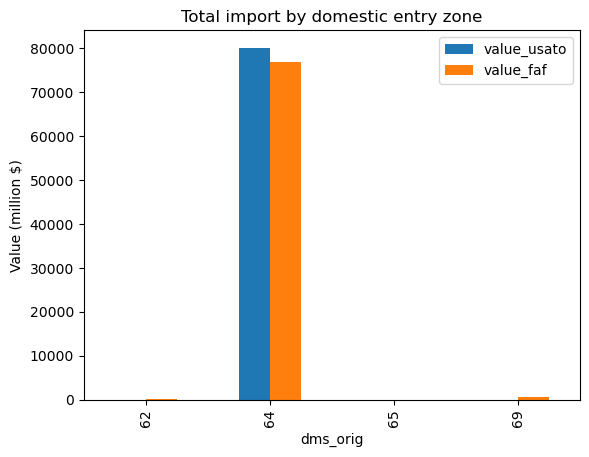

In [18]:
# Compare import (due to ~15% discrepancy)
usato_import_by_faf = \
usato_import_in_region.groupby('FAF')[['Customs Value (Gen) ($US)']].sum()
usato_import_by_faf = usato_import_by_faf.reset_index()

usato_import_by_faf['Customs Value (Gen) ($US)'] /= 10 ** 6
usato_import_by_faf.columns = ['dms_orig', 'value_usato']
faf_import_agg = \
regional_import.groupby('dms_orig')[['value_2017']].sum()
faf_import_agg = faf_import_agg.reset_index()
faf_import_agg.columns = ['dms_orig', 'value_faf']
import_value_compare = pd.merge(usato_import_by_faf,
                               faf_import_agg, on = 'dms_orig',
                               how = 'left')

import_value_compare.plot(x = 'dms_orig', kind = 'bar')
plt.title('Total import by domestic entry zone')
plt.ylabel('Value (million $)')
plt.savefig(os.path.join(path_to_plot, 'import_by_domestic_entry.png'),
           dpi = 300, bbox_inches = 'tight')
import_value_compare

['Asia & Oceania' 'Canada' 'Europe & Africa' 'Mexico'
 'Rest of the Americas']


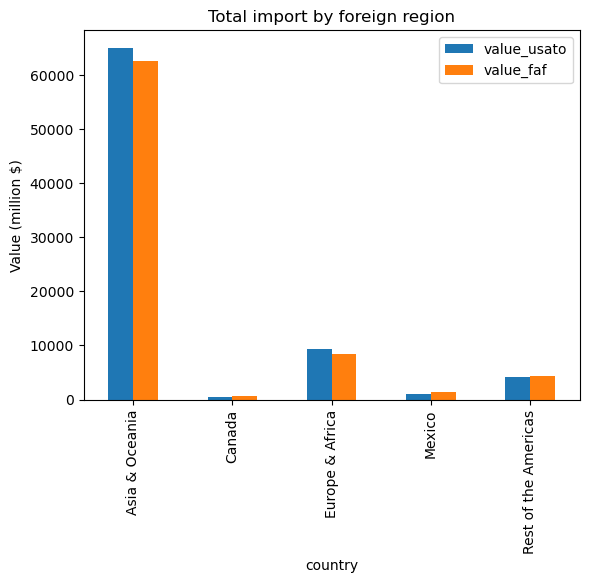

In [19]:
# Compare total import by country (due to ~15% discrepancy)
usato_import_by_country = \
usato_import_in_region.groupby('CFS_NAME')[['Customs Value (Gen) ($US)']].sum()
usato_import_by_country = usato_import_by_country.reset_index()

usato_import_by_country['Customs Value (Gen) ($US)'] /= 10 ** 6
usato_import_by_country.columns = ['country', 'value_usato']
faf_import_by_country = \
regional_import.groupby('CFS_NAME')[['value_2017']].sum()
faf_import_by_country = faf_import_by_country.reset_index()
faf_import_by_country.columns = ['country', 'value_faf']
import_value_compare = pd.merge(usato_import_by_country,
                               faf_import_by_country, 
                                on = 'country',
                               how = 'left')

import_value_compare.plot(x = 'country', kind = 'bar')
plt.title('Total import by foreign region')
plt.ylabel('Value (million $)')
plt.savefig(os.path.join(path_to_plot, 'import_by_foreign_region.png'),
           dpi = 300, bbox_inches = 'tight')
print(import_value_compare.country.unique())

In [20]:
# look into central zone a bit more

region_to_check = 531
usato_import_sel = \
usato_import_in_region.loc[usato_import_in_region['FAF'] == region_to_check]
usato_import_sel['Customs Value (Gen) ($US)'] /= 10 ** 6

usato_import_sel = usato_import_sel[['CBP Port Location', 'Customs Value (Gen) ($US)']]
usato_import_sel.columns = ['Port Location', 'Values (million)']
usato_import_sel.loc[:, 'Label'] = 'Import'
# usato_import_sel = \
# pd.pivot_table(usato_import_sel, columns = 'CBP Port Location', 
#                values = 'Customs Value (Gen) ($US)', aggfunc = 'sum')
usato_export_sel = \
usato_export_in_region.loc[usato_export_in_region['FAF'] == region_to_check]
usato_export_sel['Total Exports Value ($US)'] /= 10 ** 6

usato_export_sel = usato_export_sel[['CBP Port Location', 'Total Exports Value ($US)']]
usato_export_sel.columns = ['Port Location', 'Values (million)']
usato_export_sel.loc[:, 'Label'] = 'Export'

usato_international_shipment = \
pd.concat([usato_import_sel, usato_export_sel])
usato_international_shipment = \
pd.pivot_table(usato_international_shipment, 
               index= 'Label',
               columns = 'Port Location', 
               values = 'Values (million)', aggfunc = 'sum')

# faf_import_sea = faf_import_agg.loc[faf_import_agg['dms_orig'] == 64]
# ax = faf_import_sea['value_faf'].plot.bar(ylabel="Value", xlabel="Source", figsize=(6,4), color='green', position=1)
ax = usato_international_shipment.plot.bar(stacked=True)
# faf_import_sea['value_faf'].plot.bar(ylabel="Value", xlabel="Source", 
#                                      color='green',  position = -0.5,ax = ax)
plt.xlabel('')
plt.xticks(rotation = 30)
plt.ylabel('Total value (million$)')
plt.legend(fontsize = 10, bbox_to_anchor = (1.01, 1))
plt.savefig(os.path.join(path_to_plot, 'international_flow.png'), 
            dpi = 300,  bbox_inches = 'tight')
usato_international_shipment.head(5)

ValueError: cannot set a frame with no defined index and a scalar

,dms_dest,value_usato,value_faf
0,62,89.748671,89.845799
1,64,54509.262543,55461.294609
2,65,1.977640,1.951359
3,69,18.919162,51.042575


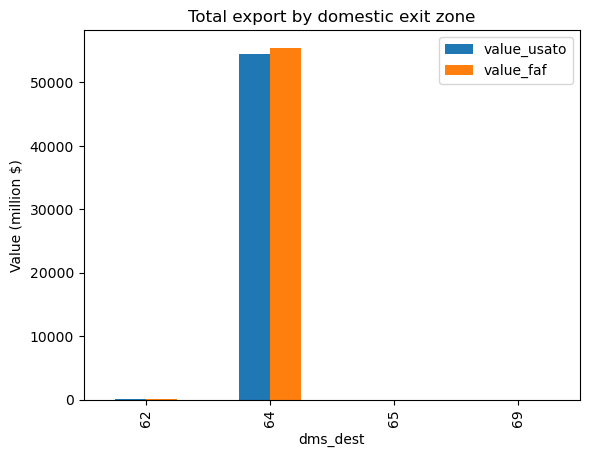

In [21]:
# compare export by faf zone

usato_export_by_faf = \
usato_export_in_region.groupby('FAF')[['Total Exports Value ($US)']].sum()
usato_export_by_faf = usato_export_by_faf.reset_index()

usato_export_by_faf['Total Exports Value ($US)'] /= 10 ** 6
usato_export_by_faf.columns = ['dms_dest', 'value_usato']
faf_export_agg = \
regional_export.groupby('dms_dest')[['value_2017']].sum()
faf_export_agg = faf_export_agg.reset_index()
faf_export_agg.columns = ['dms_dest', 'value_faf']
export_value_compare = pd.merge(usato_export_by_faf,
                               faf_export_agg, on = 'dms_dest',
                               how = 'left')

export_value_compare.plot(x = 'dms_dest', kind = 'bar')
plt.title('Total export by domestic exit zone')
plt.ylabel('Value (million $)')
plt.savefig(os.path.join(path_to_plot, 'import_by_domestic_exit.png'),
           dpi = 300, bbox_inches = 'tight')
export_value_compare

,country,value_usato,value_faf
0,Asia & Oceania,40783.491956,41328.862213
1,Canada,139.561638,143.292894
2,Europe & Africa,10608.454723,10216.897929
3,Mexico,1102.596561,1146.350754
4,Rest of the Americas,1985.803138,2768.730552


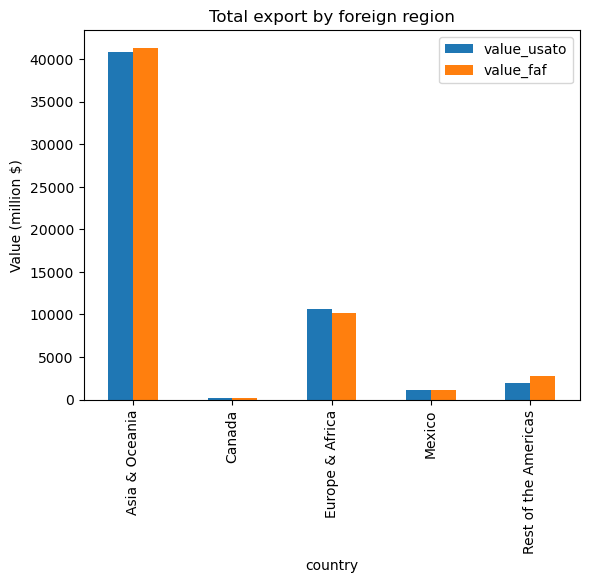

In [22]:
# compare export by foreign destination

usato_export_by_country = \
usato_export_in_region.groupby(['CFS_NAME'])[['Total Exports Value ($US)']].sum()
usato_export_by_country = usato_export_by_country.reset_index()

usato_export_by_country['Total Exports Value ($US)'] /= 10 ** 6
usato_export_by_country.columns = ['country', 'value_usato']
faf_export_by_country = \
regional_export.groupby(['CFS_NAME'])[['value_2017']].sum()
faf_export_by_country = faf_export_by_country.reset_index()
faf_export_by_country.columns = ['country', 'value_faf']
export_value_compare = pd.merge(usato_export_by_country,
                               faf_export_by_country, on = 'country',
                               how = 'left')

export_value_compare.plot(x = 'country', kind = 'bar')
plt.title('Total export by foreign region')
plt.ylabel('Value (million $)')
plt.savefig(os.path.join(path_to_plot, 'export_by_foreign.png'),
           dpi = 300, bbox_inches = 'tight')
export_value_compare

,FAF,country,value,source
0,62,Asia & Oceania,81.410536,usato
1,62,Canada,2.134814,usato
2,62,Europe & Africa,2.299369,usato
3,62,Mexico,0.068368,usato
4,62,Rest of the Americas,0.885688,usato
5,64,Asia & Oceania,39931.003290,usato
6,64,Canada,132.834228,usato
7,64,Europe & Africa,10240.119013,usato
8,64,Mexico,1094.945734,usato
9,64,Rest of the Americas,1983.955365,usato


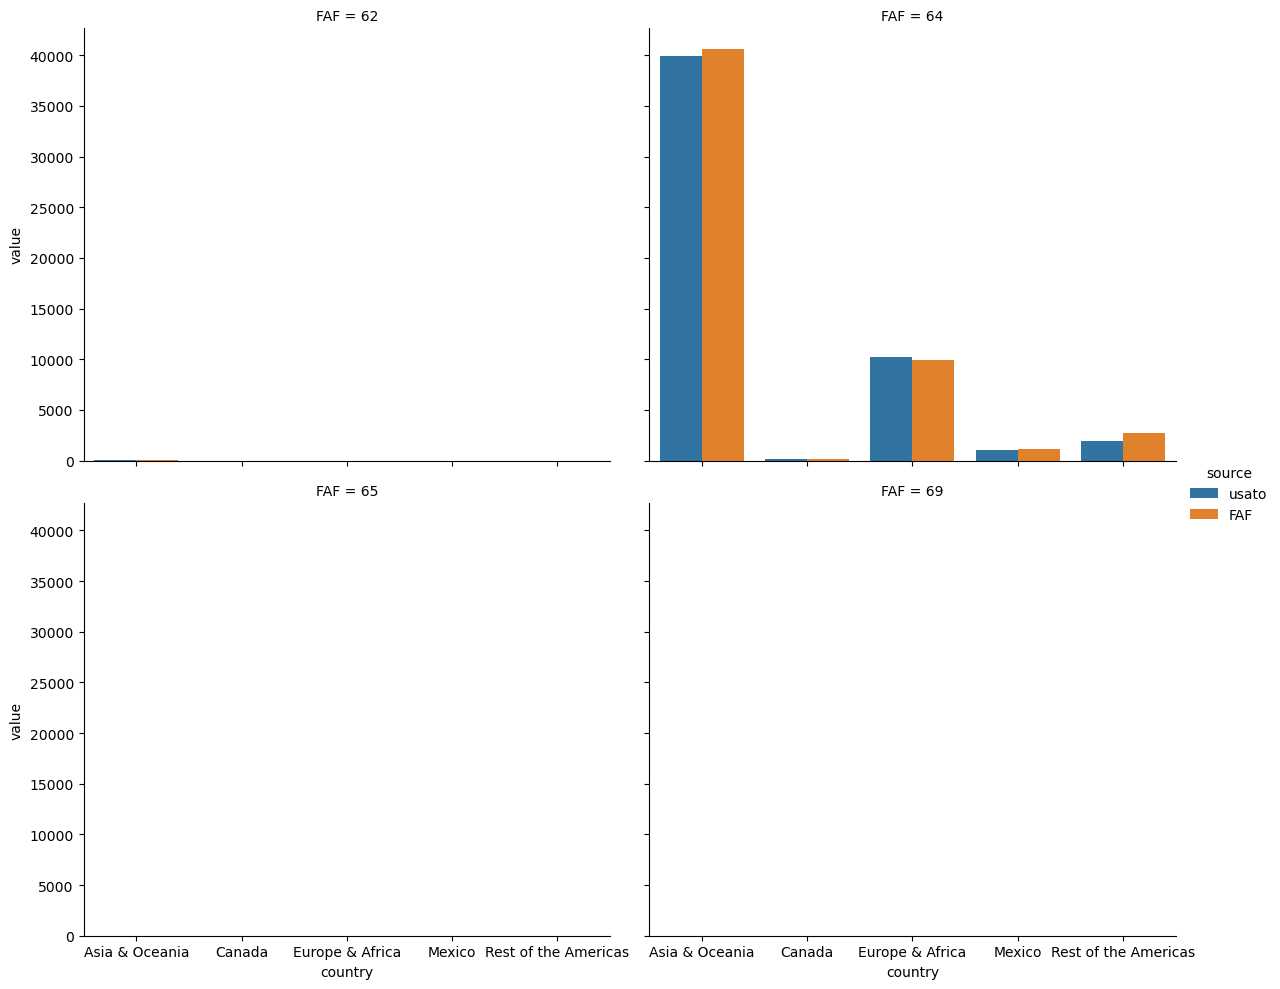

In [16]:
# compare export by foreign destination
# drop aircraft

usato_export_by_country = \
usato_export_in_region.groupby(['FAF', 'CFS_NAME'])[['Total Exports Value ($US)']].sum()
usato_export_by_country = usato_export_by_country.reset_index()

usato_export_by_country['Total Exports Value ($US)'] /= 10 ** 6
usato_export_by_country.columns = ['FAF', 'country', 'value']
usato_export_by_country.loc[:, 'source'] = 'usato'
faf_export_by_country = \
regional_export.groupby(['dms_dest', 'CFS_NAME'])[['value_2017']].sum()
faf_export_by_country = faf_export_by_country.reset_index()
faf_export_by_country.columns = ['FAF', 'country', 'value']
faf_export_by_country.loc[:, 'source'] = 'FAF'
export_value_compare = pd.concat([usato_export_by_country,
                               faf_export_by_country])

sns.catplot(data = export_value_compare,
            x = 'country', y = 'value', hue = 'source', col = 'FAF',
            col_wrap = 2, aspect = 1.2, height = 5,
            kind = 'bar')
export_value_compare

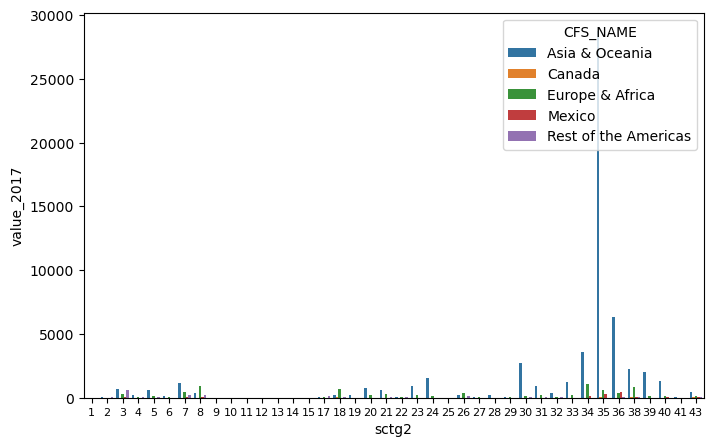

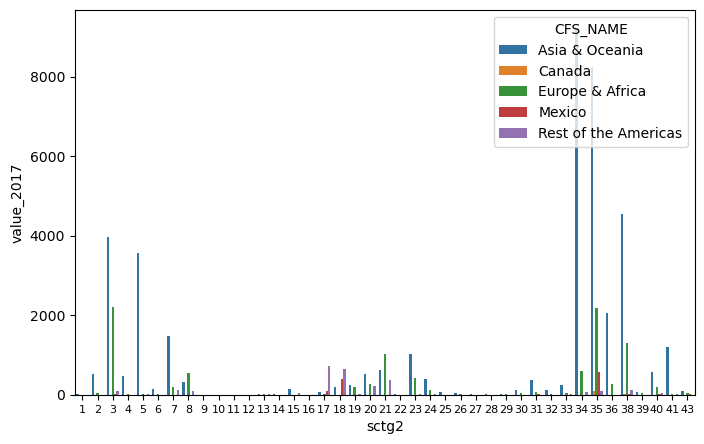

In [17]:
# check by sctg distribution by country
faf_import_by_sctg = \
regional_import.groupby(['CFS_NAME', 'sctg2'])[['value_2017']].sum()
faf_import_by_sctg = faf_import_by_sctg.reset_index()

plt.figure(figsize = (8,5))
sns.barplot(faf_import_by_sctg, x= 'sctg2', y = 'value_2017', 
            hue = 'CFS_NAME')
plt.xticks(fontsize = 8)
plt.show()

faf_export_by_sctg = \
regional_export.groupby(['CFS_NAME', 'sctg2'])[['value_2017']].sum()
faf_export_by_sctg = faf_export_by_sctg.reset_index()

plt.figure(figsize = (8,5))
sns.barplot(faf_export_by_sctg, x= 'sctg2', y = 'value_2017', 
            hue = 'CFS_NAME')
plt.xticks(fontsize = 8)
plt.show()